# Annotate RBC-GEM

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    MODEL_PATH,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    read_rbc_model,
    write_rbc_model,
    split_string,
    show_versions,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
old_model = read_rbc_model(filetype="xml")
old_model

Name,RBC_GEM
Memory address,14d17ebd0
Number of metabolites,1955
Number of reactions,2777
Number of genes,649
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Set annotations on model

In [4]:
replace_annotations = True
annotation_types = ["reactions", "metabolites", "genes"]
model = old_model.copy()

for annotation_type in annotation_types:
    df_annotation = pd.read_csv(
        f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
        sep="\t",
        index_col=0,
        dtype=str,
    )
    for idx, row in df_annotation.set_index(annotation_type).iterrows():
        try:
            item = getattr(model, annotation_type).get_by_id(idx)
        except KeyError:
            continue
        values = {k: split_string(v) for k, v in row.dropna().to_dict().items()}
        values.update({k: v[0] for k, v in values.items() if len(v) == 1})
        if replace_annotations:
            item.annotation = values
        else:
            item.annotation.update(values)

### Compare before overwriting

In [5]:
df_old_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(old_model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_old_model[annotation_type] = get_annotation_df(
        getattr(old_model, annotation_type), sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)

df_new_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_new_model[annotation_type] = get_annotation_df(
        getattr(model, annotation_type), sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)

<Axes: xlabel='reactions'>

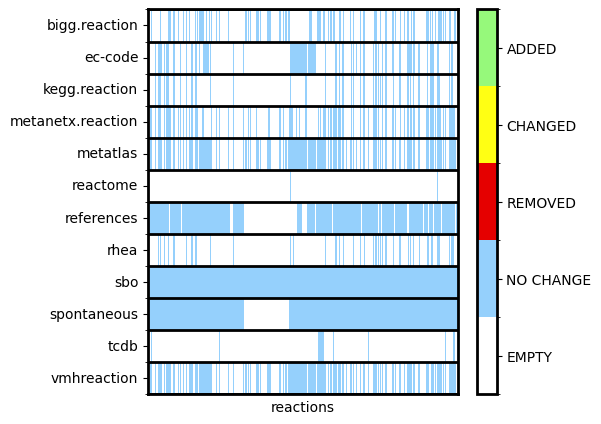

In [6]:
annotation_type = "reactions"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='metabolites'>

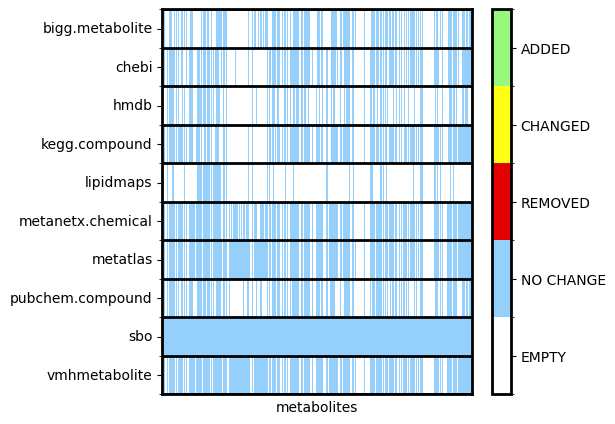

In [7]:
annotation_type = "metabolites"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='genes'>

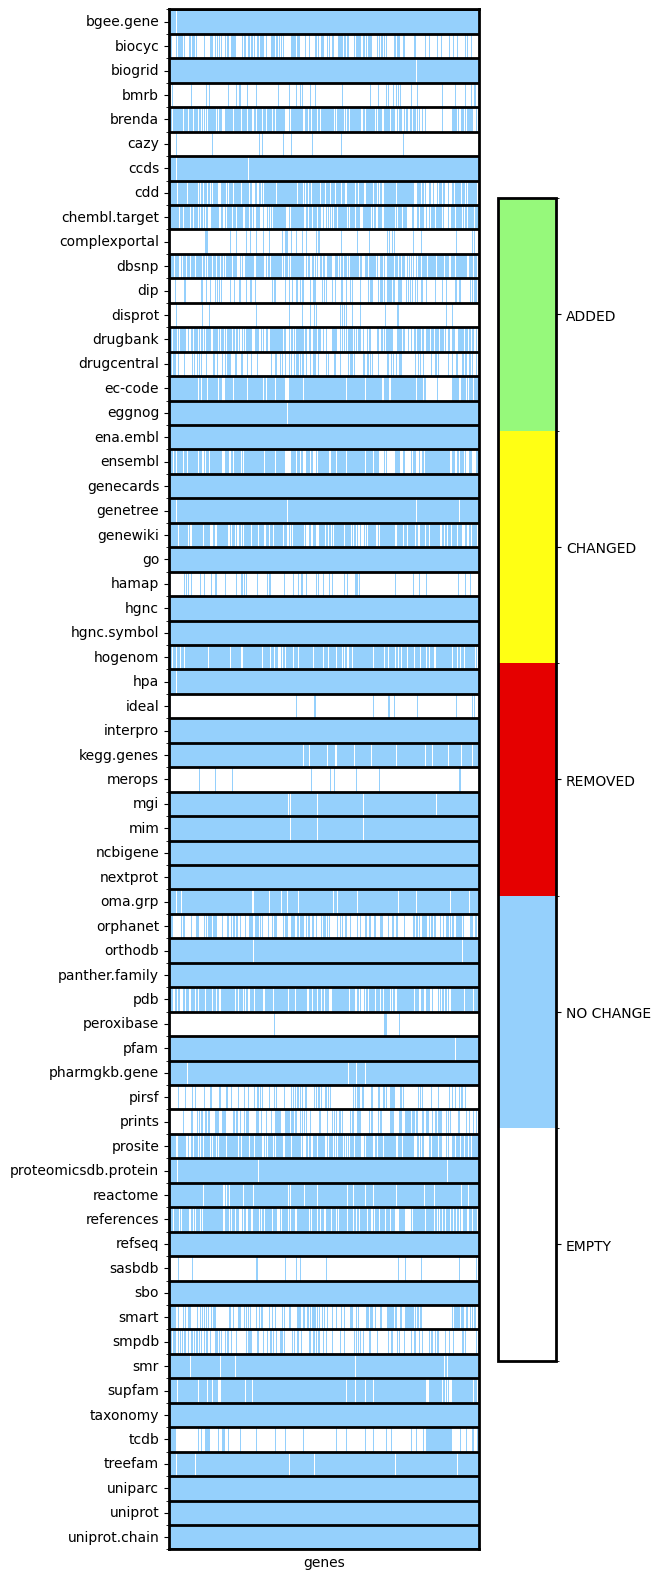

In [8]:
annotation_type = "genes"
fig, ax = plt.subplots(1, 1, figsize=(5, 20))

df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

## Export model

In [9]:
write_rbc_model(model)